# Regression with an Abalone Dataset


### Description du jeu de données : 

- L'ensemble de données pour cette compétition (à la fois pour la formation et le test) a été généré à partir d'un modèle d'apprentissage profond formé sur l'ensemble de données Abalone. Les distributions des caractéristiques sont proches, mais pas exactement les mêmes, que celles de l'original. 

- **Votre objectif** : L'objectif de ce concours est de prédire l'âge des ormeaux à partir de diverses mesures physiques


Disponible sur : https://www.kaggle.com/competitions/playground-series-s4e4/overview

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line


In [1]:
### Imports 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import missingno as msno


#test statistique : 
from scipy.stats import spearmanr, kendalltau,pearsonr, shapiro

#import outils reductions dimensions
from sklearn.decomposition import PCA #linéaire
from sklearn.manifold import TSNE #non linéaire pour structure locale




#package modele non supervisé
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer #permet tracer courbe pour choisir bonne valeur KMeans
from sklearn.cluster import KMeans



import os
import warnings
warnings.filterwarnings("ignore")

# Plan : 

#### 1. Connaissance du jeu de données 
- Présence d'une target ?
- Que signifie les features
- Dimensions des données
- Type de données et cohérence (variables discrètes : int, continues : float, qualitative : str)
- Présence de données manquantes ? 

#### 2. Analyse univariée
- Variables discrètes
- Variables continues
- Variables qualitatives


In [13]:
path = r"D:\\Etude_Data_science\\Kaggle_competition\\05_Regression_with_an_Abalone_Dataset\\datasets\\"

In [15]:
data = pd.read_csv(path+"train.csv")
df = data.copy()

In [16]:
df.shape

(90615, 10)

In [17]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


* **Abalone** = mollusque, pour lesquels on va avoir différents paramètres mesurés.
- Features :
- id; pour identifier l'individu
- Sex, Length, Diameter, Height sont des paramètres sur la taille de l'individus et son sexe
- Whole weight.1/2 sont les poids totaux
- Shell weight : pids de la coque
- **Rings** : anneaux, c'est **la target a prédire**, et elle est de type **integer** ( on peut supposer discrète)

#### Kaggle evaluera les performances du modèle avec la RMSLE (Root Mean Squared Logarithmic Error) donc on peut considérer la target comme un problème de régression avec des données positives ou nulles (mais non négatives)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


Concernant le reste des infos, il y a une cohérence entre le dtype d'une feature et la feature elle même 
- integer pour des variables quantitatives discrètes,
- object pour variable qualitative 
- float pour des variables quantitatives continues

* On notera par la même occasion qu'il **n'y a pas de données manquantes donc pas besoin d'imputation**

# 2. Analyse univariée
#### Séparation des données en fonction du type de variable

In [25]:
#Retirons l'id car nous n'allons pas l'analyser :
identifiant = df.id
df = df.drop("id", axis = 1)

In [31]:
#Séparons les données 
var_dis = list(df.select_dtypes(int).columns)
var_cont = list(df.select_dtypes(float))
var_qual = list(df.select_dtypes(object))

### 2.1 Variables discrètes
- Nous avons vu dans la section précédente que le type de donnée était cohérent avec la feature elle même, donc on peut facilement séparer les types de données

In [39]:
var_dis #Seulement une colonne a analyser

['Rings']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

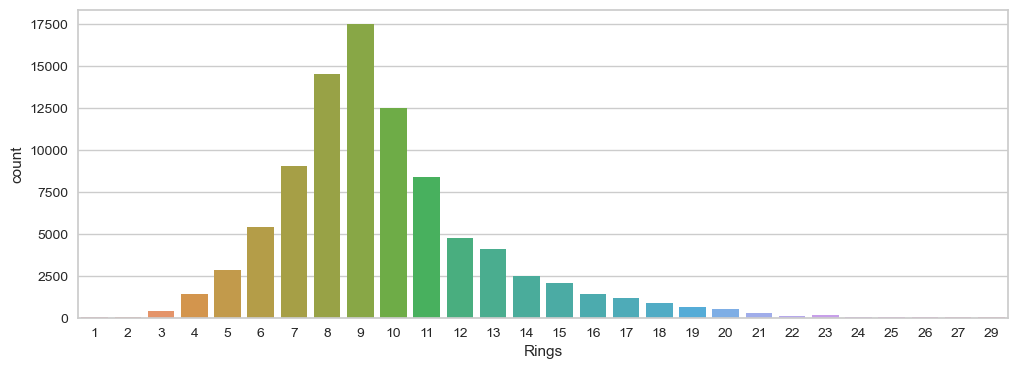

Mean : 9.7
Mode : 9


In [49]:
plt.figure(figsize=(12,4))
sns.countplot(data = df[var_dis], x = var_dis[0] )
plt.show()
print("Mean :",round(df[var_dis[0]].mean(),2))
print("Mode :",df.Rings.mode()[0])

* On voit très clairement ici que notre target suit une loi de distribution normale, avec un mode de 9 anneaux et une moyenne de 9.7
* La gamme s'étend de 1 anneau à 29

### 2.2 Variables continues


In [58]:
print(var_cont)
print("Il y a", len(var_cont), "features à analyser ")

['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
Il y a 7 features à analyser 


<IPython.core.display.Javascript object>

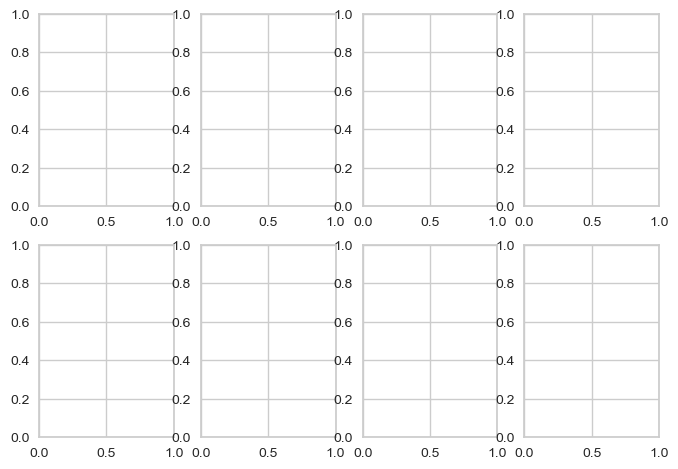

In [59]:
#On va créer un subplot de dimension (2,4) pour analyser toutes ces variables
fig, axes = plt.subplots(2,4) #2 lignes et 4 colonnes

### 2.3 Variables qualitatives